Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)



In [1]:
airbnb<-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)

In [2]:
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [3]:
airbnb <- airbnb %>% select('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude')
head(airbnb)

City,Room.Type,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude
London,Entire home/apt,,1,1.0,1,1,50,NA,1,20,90,51.49247,-0.1886284
London,Entire home/apt,LB of Richmond upon Thames,8,2.5,5,5,175,NA,6,25,87,51.48200,-0.2392775
London,Entire home/apt,,2,1.0,1,1,155,NA,1,0,NA,51.51579,-0.1363321
Madrid,Private room,Palacio,2,1.0,1,1,36,NA,1,0,98,40.41011,-3.7147540
Madrid,Entire home/apt,Palacio,2,1.0,1,1,85,NA,1,0,95,40.41697,-3.7094389
Madrid,Private room,La Latina,2,1.0,1,1,20,861,1,10,91,40.40971,-3.7135612


Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [4]:
df_madrid <- airbnb %>% filter(Room.Type == "Entire home/apt", City == "Madrid", Neighbourhood != "")

Crea una nueva columna llamada Square.Meters a partir de Square.Feet. Recuerda que un pie cuadrado son 0.092903 metros cuadrados.

In [5]:
df_madrid$Square.Meters <- df_madrid$Square.Feet * 0.092903

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [6]:
na <- nrow(df_madrid[which(is.na(df_madrid$Square.Meters)),])
paste("Numero de Registros con NA en Square Meters: ", na)
paste("Porcentaje de apartamentos con NA en Square Meters: ", round((na*100)/nrow(df_madrid),2), "%", sep="")

[1] "Numero de Registros con NA en Square Meters:  5254"

[1] "Porcentaje de apartamentos con NA en Square Meters: 93.8%"

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [7]:
sm0 <- nrow(df_madrid[which(df_madrid$Square.Meters == 0),])
paste("Numero de Registros con 0 en Square Meters: ", sm0)
paste("Porcentaje de apartamentos con 0 en Square Meters: ", round((sm0*100)/nrow(df_madrid),2), "%", sep="")

[1] "Numero de Registros con 0 en Square Meters:  128"

[1] "Porcentaje de apartamentos con 0 en Square Meters: 2.29%"

Reemplazar todos los 0m^2 por NA 

In [8]:
df_madrid$Square.Meters[df_madrid$Square.Meters == 0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA. Pero **antes de crear el modelo** vamos a hacer:
* pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.
* crearemos una variable sintética nueva basada en la similitud entre barrios que usaremos en nuestro modelo.

Pinta el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 5382 rows containing non-finite values (stat_bin).”

[1] "Limpiamos los Outliers"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 5383 rows containing non-finite values (stat_bin).”

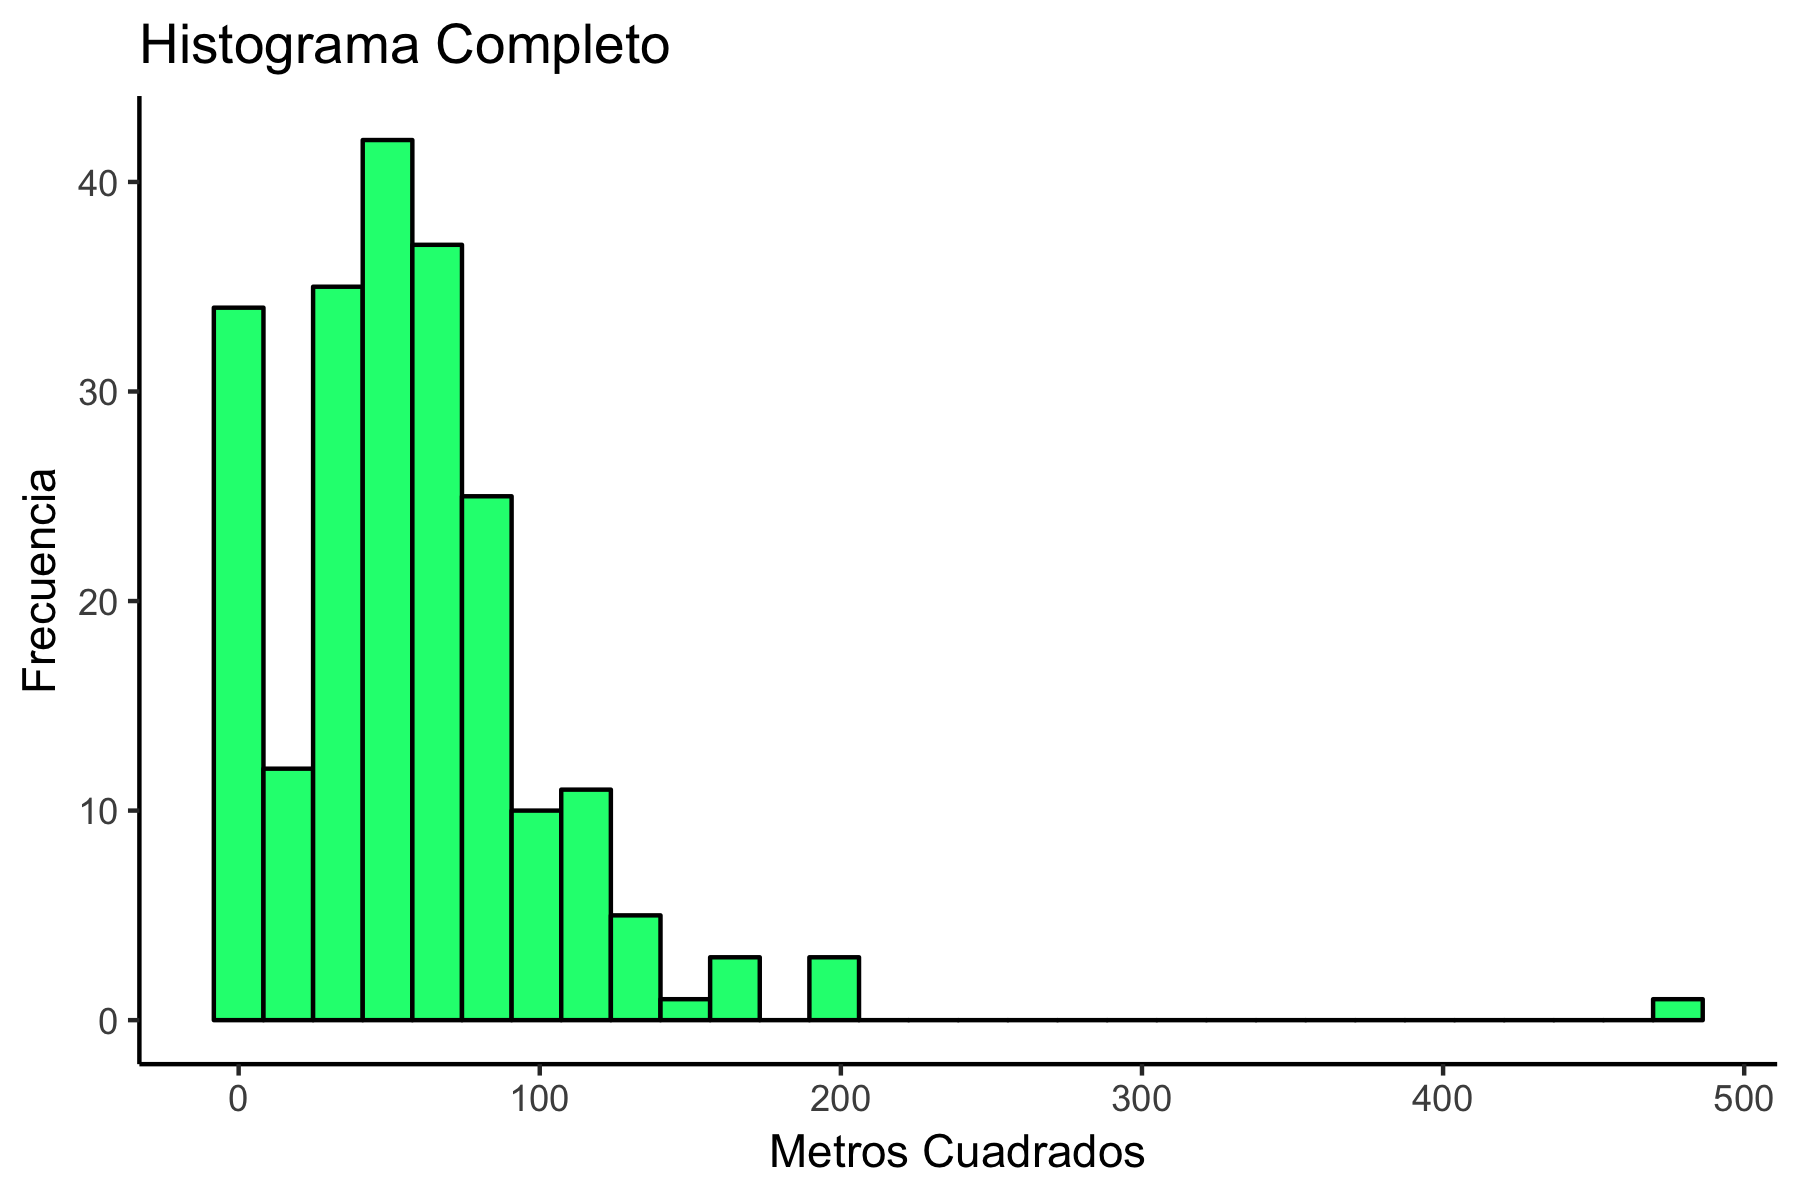

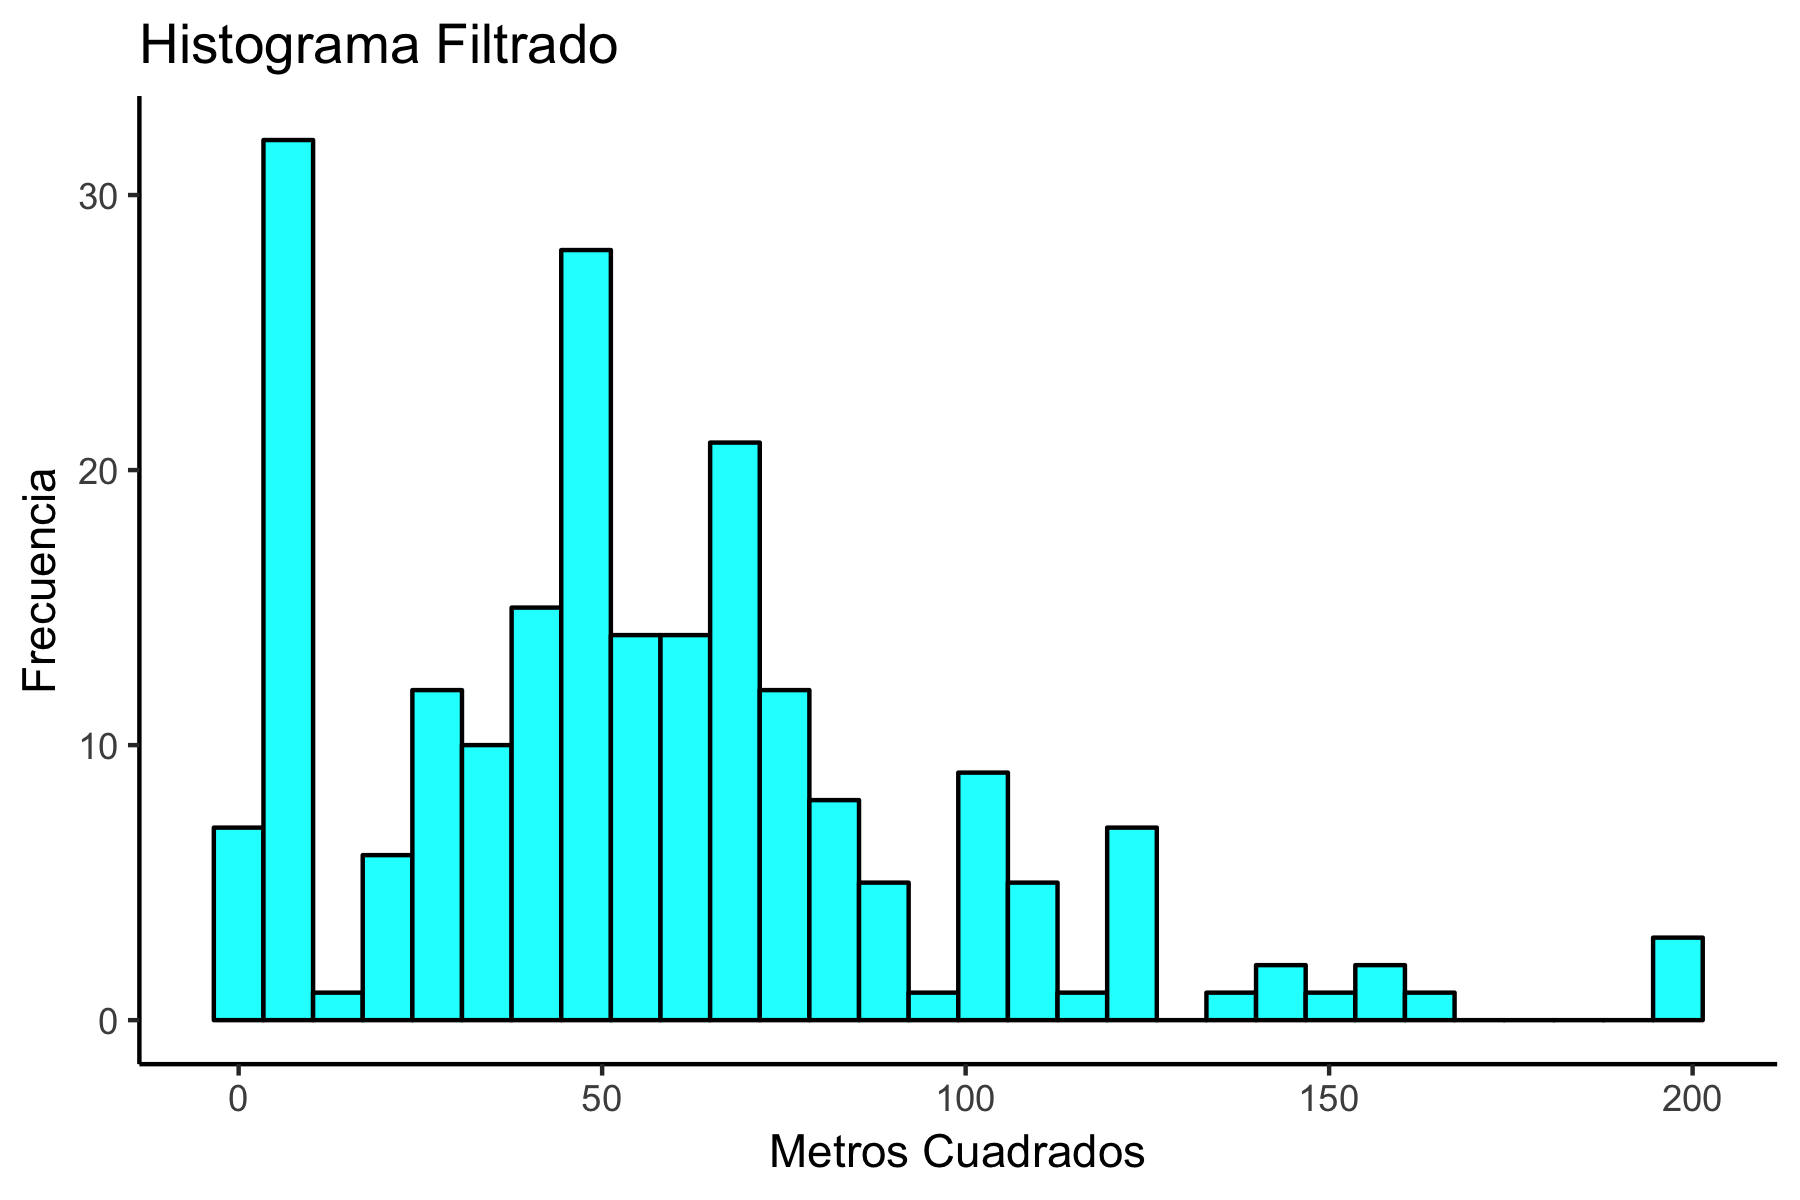

In [9]:
ggplot(df_madrid, aes (x = Square.Meters)) + geom_histogram(fill = "springgreen1", color = "black") + 
ggtitle("Histograma Completo") + 
xlab("Metros Cuadrados") + 
ylab("Frecuencia") +
theme_classic()

paste("Limpiamos los Outliers")
df_madrid$Square.Meters[df_madrid$Square.Meters > 400] <- NA

ggplot(df_madrid, aes (x = Square.Meters)) + geom_histogram(fill = "cyan", color = "black") + 
ggtitle("Histograma Filtrado") + 
xlab("Metros Cuadrados") + 
ylab("Frecuencia") +
theme_classic()

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [10]:
df_madrid$Square.Meters[df_madrid$Square.Meters < 20] <- NA

Existen varios Barrios que todas sus entradas de Square.Meters son NA, vamos a eliminar del dataset todos los pisos que pertenecen a estos barrios.

In [11]:
GroupBarrios <- df_madrid %>% group_by(Neighbourhood) %>% summarize(num_no_na=length(na.omit(Square.Meters)), num_total=length(Square.Meters))

for (i in (1:length(GroupBarrios$num_no_na))) {
    if (GroupBarrios$num_no_na[i]==0) {
        df_madrid<- df_madrid[!(df_madrid$Neighbourhood == GroupBarrios$Neighbourhood[i]),]
    }
}

GroupBarrios <- df_madrid %>% group_by(Neighbourhood) %>% summarize(num_no_na=length(na.omit(Square.Meters)), num_total=length(Square.Meters))

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

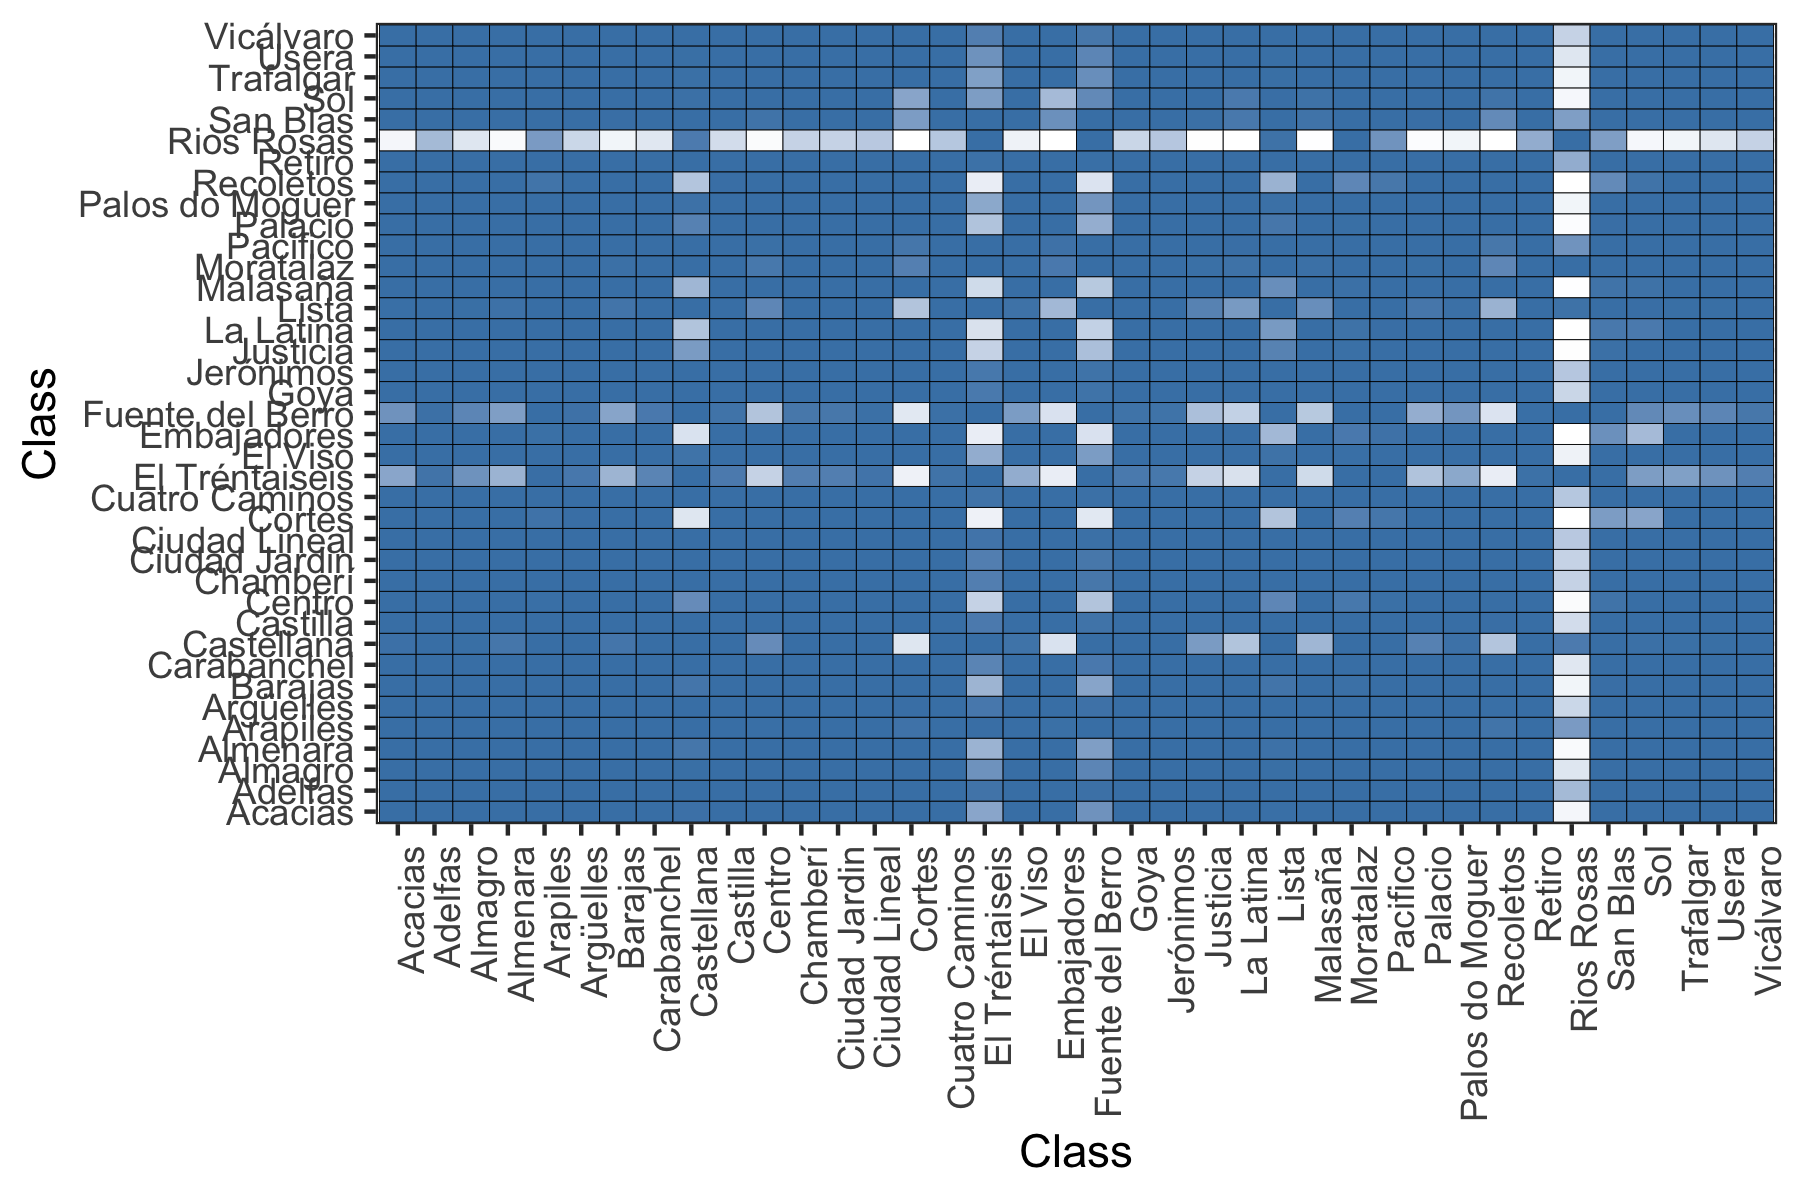

In [12]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


In [13]:
library(dendextend)


---------------------
Welcome to dendextend version 1.15.2
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------


Attaching package: ‘dendextend’

The following object is masked from ‘package:stats’:

    cutree



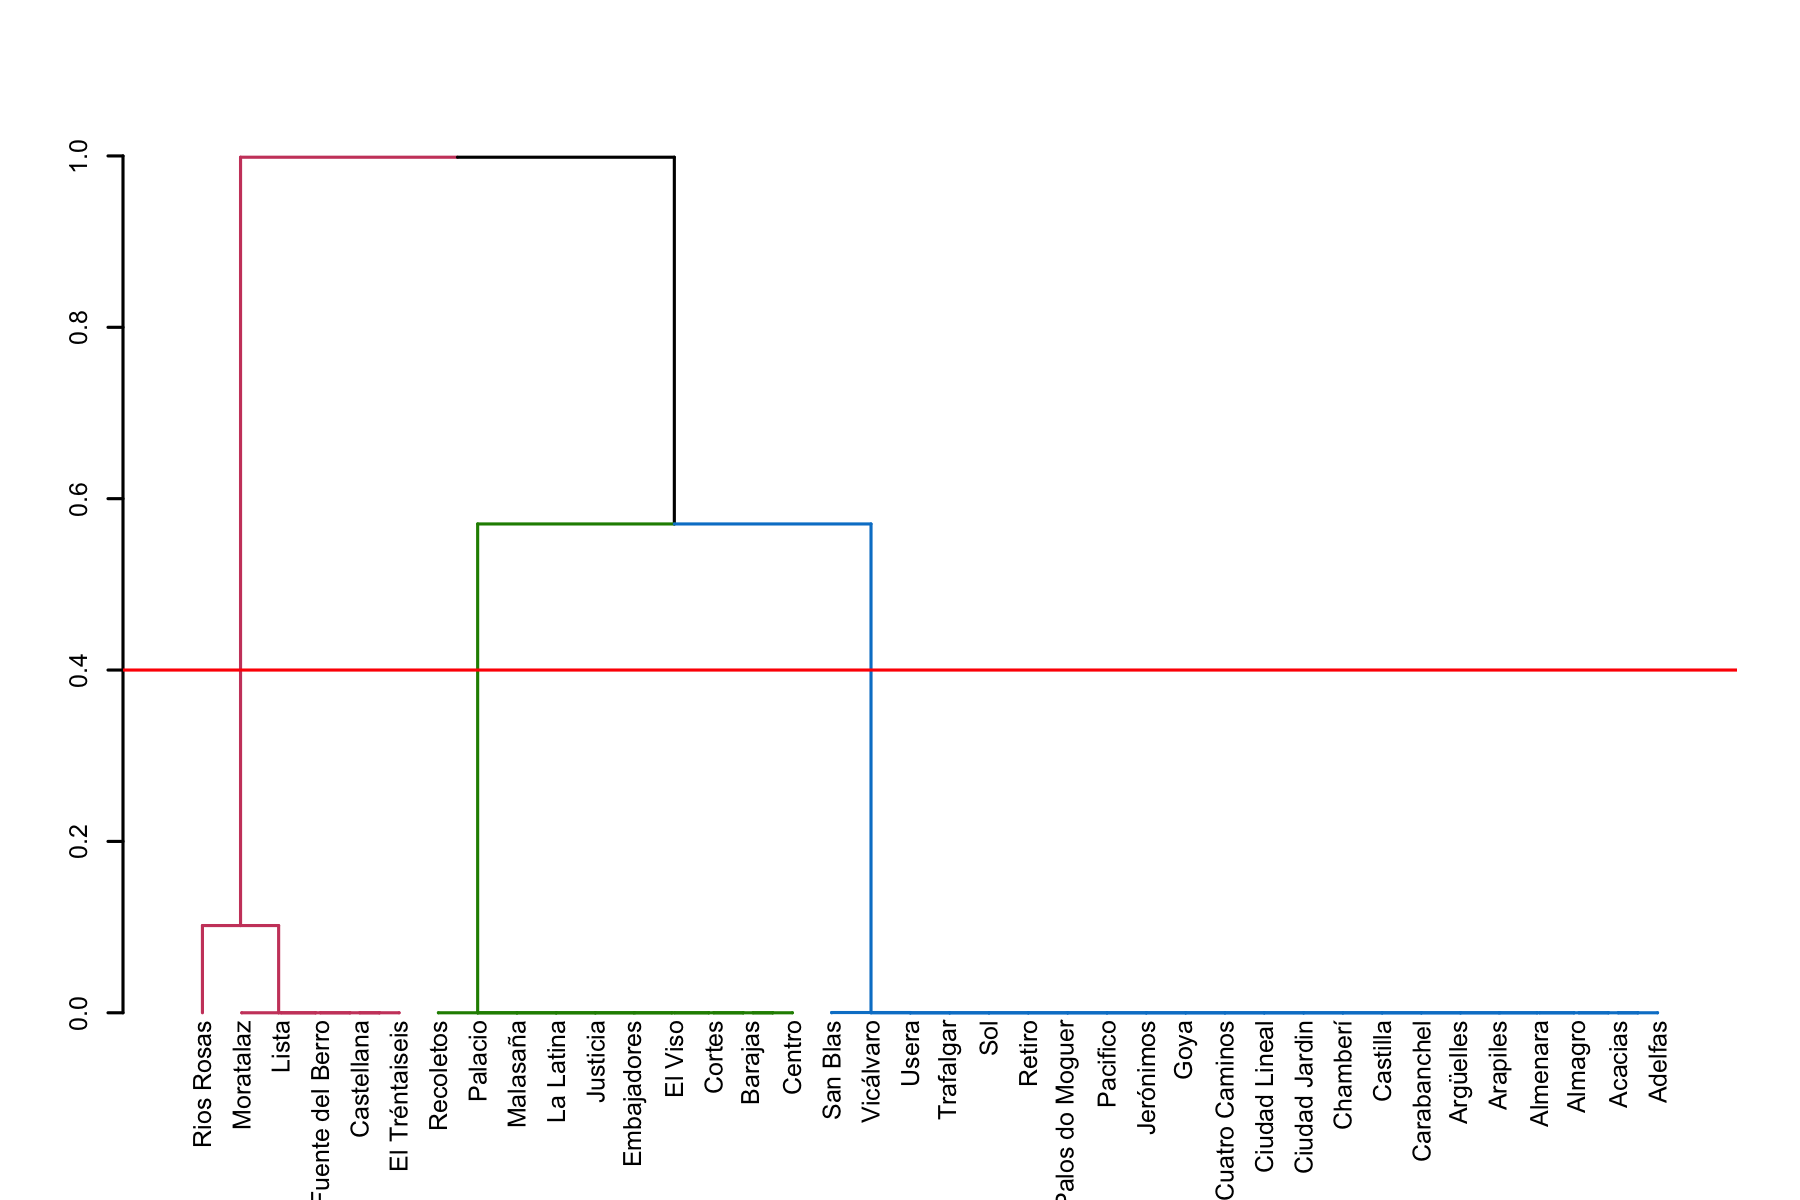

In [14]:
dist <- as.dist(1-resm)
hc <- hclust(dist, method = "complete")
dendo <- as.dendrogram(hc)

par(cex = 0.5)

plot(color_branches(dendo, k=3))
abline(h=0.4, col = "red")

¿Que punto de corte sería el aconsejable?, ¿cuantos clusters aparecen?

In [15]:
paste("Sería aconsejable tomar una distancia entre 0.1 y 0.5, generando 3 clusters")

[1] "Sería aconsejable tomar una distancia entre 0.1 y 0.5, generando 3 clusters"

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [16]:
cl <- cutree_1h.dendrogram(dendo, h=0.4)
GroupBarrios$neighb_id <- as.factor(cl)

df_madrid_cluster <- subset(merge(df_madrid, GroupBarrios), select = -c(num_no_na, num_total))

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [17]:
df_madrid2 <- df_madrid_cluster[!is.na(df_madrid_cluster$Square.Meters),]

set.seed(123)
idx = sample(1:nrow(df_madrid2), nrow(df_madrid2)*0.7)
train <- df_madrid2[idx,]
test <- df_madrid2[-idx,]

In [18]:
library(MASS)


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



In [34]:
modelo <- lm(data = train, formula = Square.Meters ~ Accommodates + Bathrooms + Bedrooms + Beds + Price + Guests.Included + Extra.People + Review.Scores.Rating + neighb_id)
summary(modelo)

paste("De acuerdo con los resultados optamos por mantener las columnas: Bathrooms, Bedrooms, Price, Extra People y neighb_id")

modelo2 <- lm(data = train, formula = Square.Meters ~ Bathrooms+Bedrooms+Price+Extra.People+as.factor(neighb_id))
summary(modelo2)


Call:
lm(formula = Square.Meters ~ Accommodates + Bathrooms + Bedrooms + 
    Beds + Price + Guests.Included + Extra.People + Review.Scores.Rating + 
    neighb_id, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-45.139  -9.374  -0.786   8.487  69.265 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -4.10706   21.59052  -0.190 0.849504    
Accommodates           2.80688    2.07304   1.354 0.178674    
Bathrooms             10.18499    4.85712   2.097 0.038426 *  
Bedrooms              18.38638    3.65521   5.030 2.06e-06 ***
Beds                  -2.43629    2.04502  -1.191 0.236237    
Price                  0.08164    0.04105   1.989 0.049374 *  
Guests.Included       -2.64091    1.84805  -1.429 0.155994    
Extra.People           0.53072    0.21003   2.527 0.013012 *  
Review.Scores.Rating   0.26407    0.22818   1.157 0.249801    
neighb_id2           -15.61569    3.98681  -3.917 0.000161 ***
neighb_id3        

[1] "De acuerdo con los resultados Obtamos por mantener las columnas: Bathrooms, Bedrooms, Price, Extra People y neighb_id"


Call:
lm(formula = Square.Meters ~ Bathrooms + Bedrooms + Price + Extra.People + 
    as.factor(neighb_id), data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-49.779 -10.670  -1.637   8.791  75.816 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            22.84252    5.82215   3.923 0.000151 ***
Bathrooms               9.51176    4.40105   2.161 0.032806 *  
Bedrooms               17.31275    2.60667   6.642 1.16e-09 ***
Price                   0.06747    0.03855   1.750 0.082840 .  
Extra.People            0.56576    0.19710   2.870 0.004901 ** 
as.factor(neighb_id)2 -15.33786    3.88846  -3.944 0.000140 ***
as.factor(neighb_id)3  22.19307    9.41356   2.358 0.020131 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.36 on 112 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.7385,	Adjusted R-squared:  0.7244 
F-statistic:  52.7 on 6 and

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

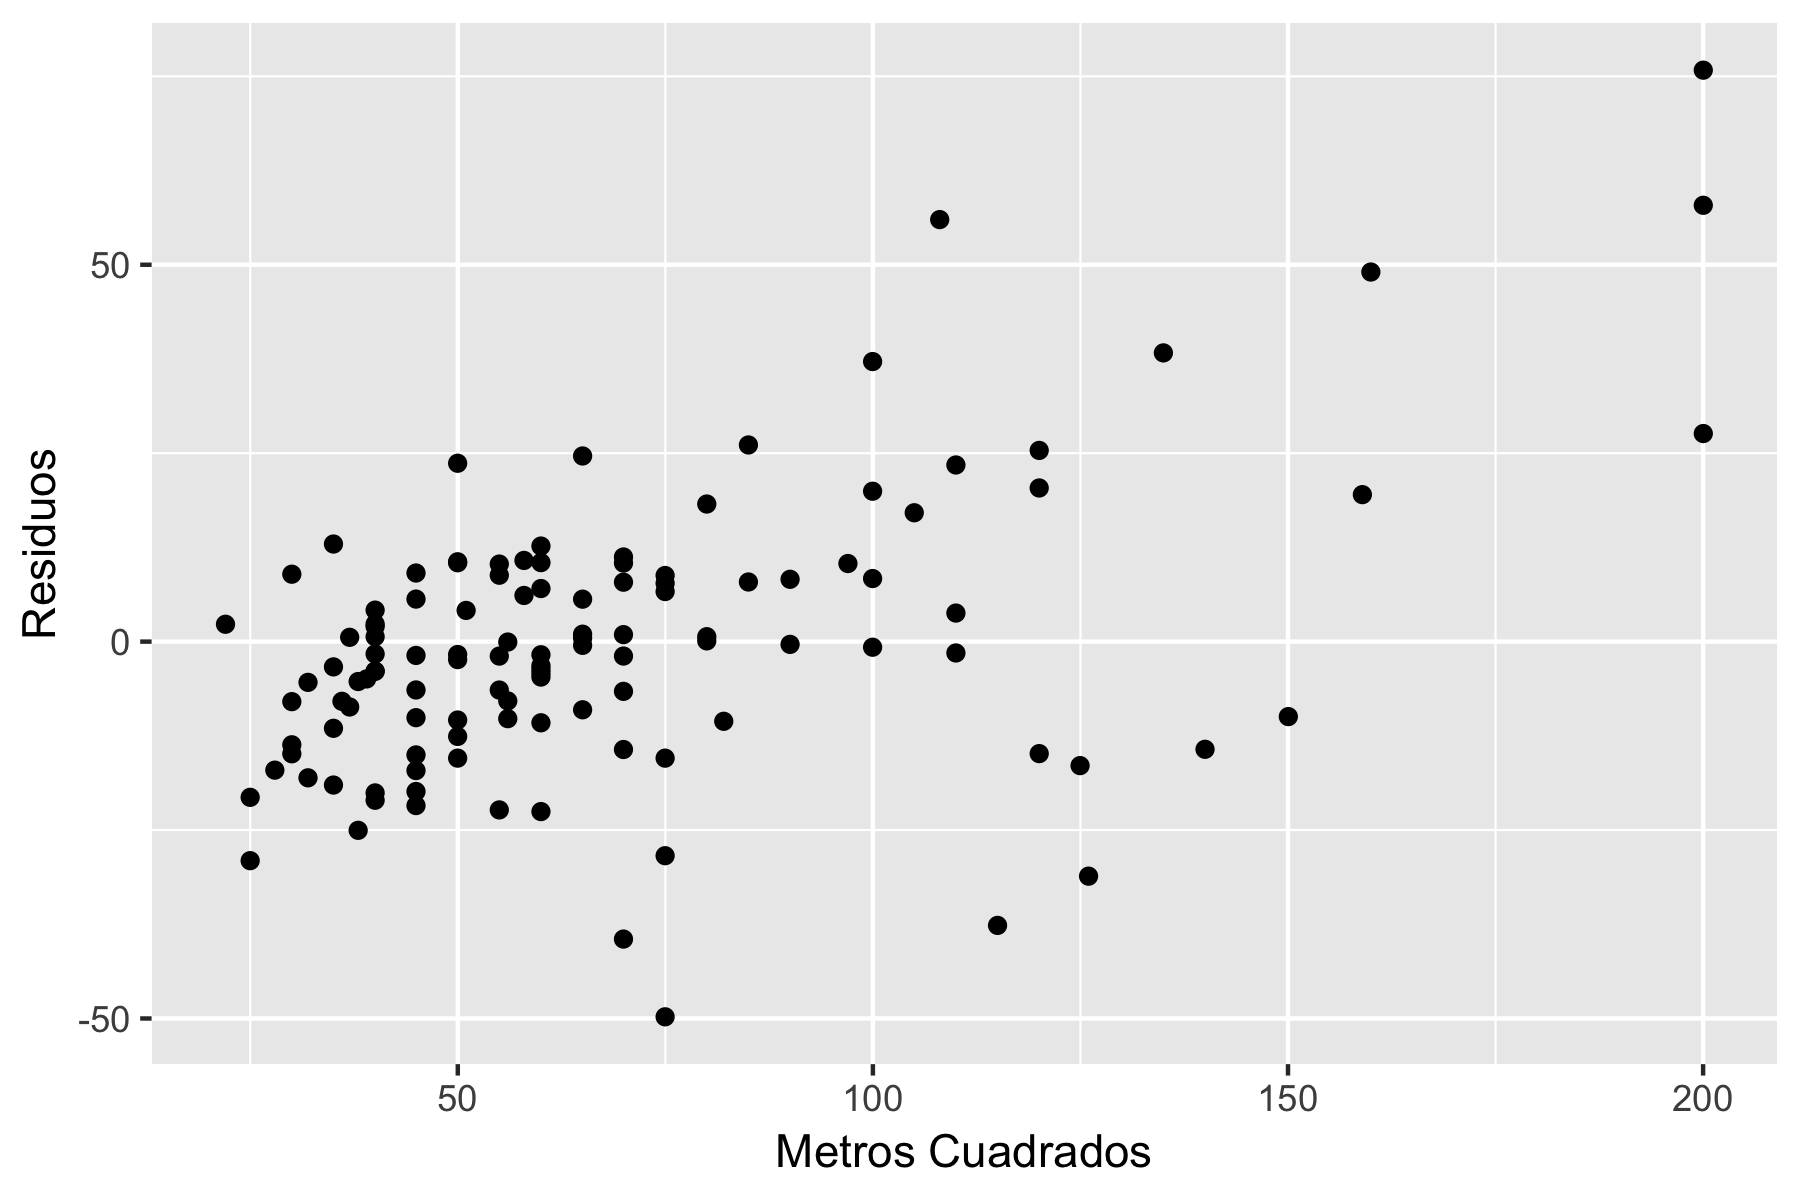

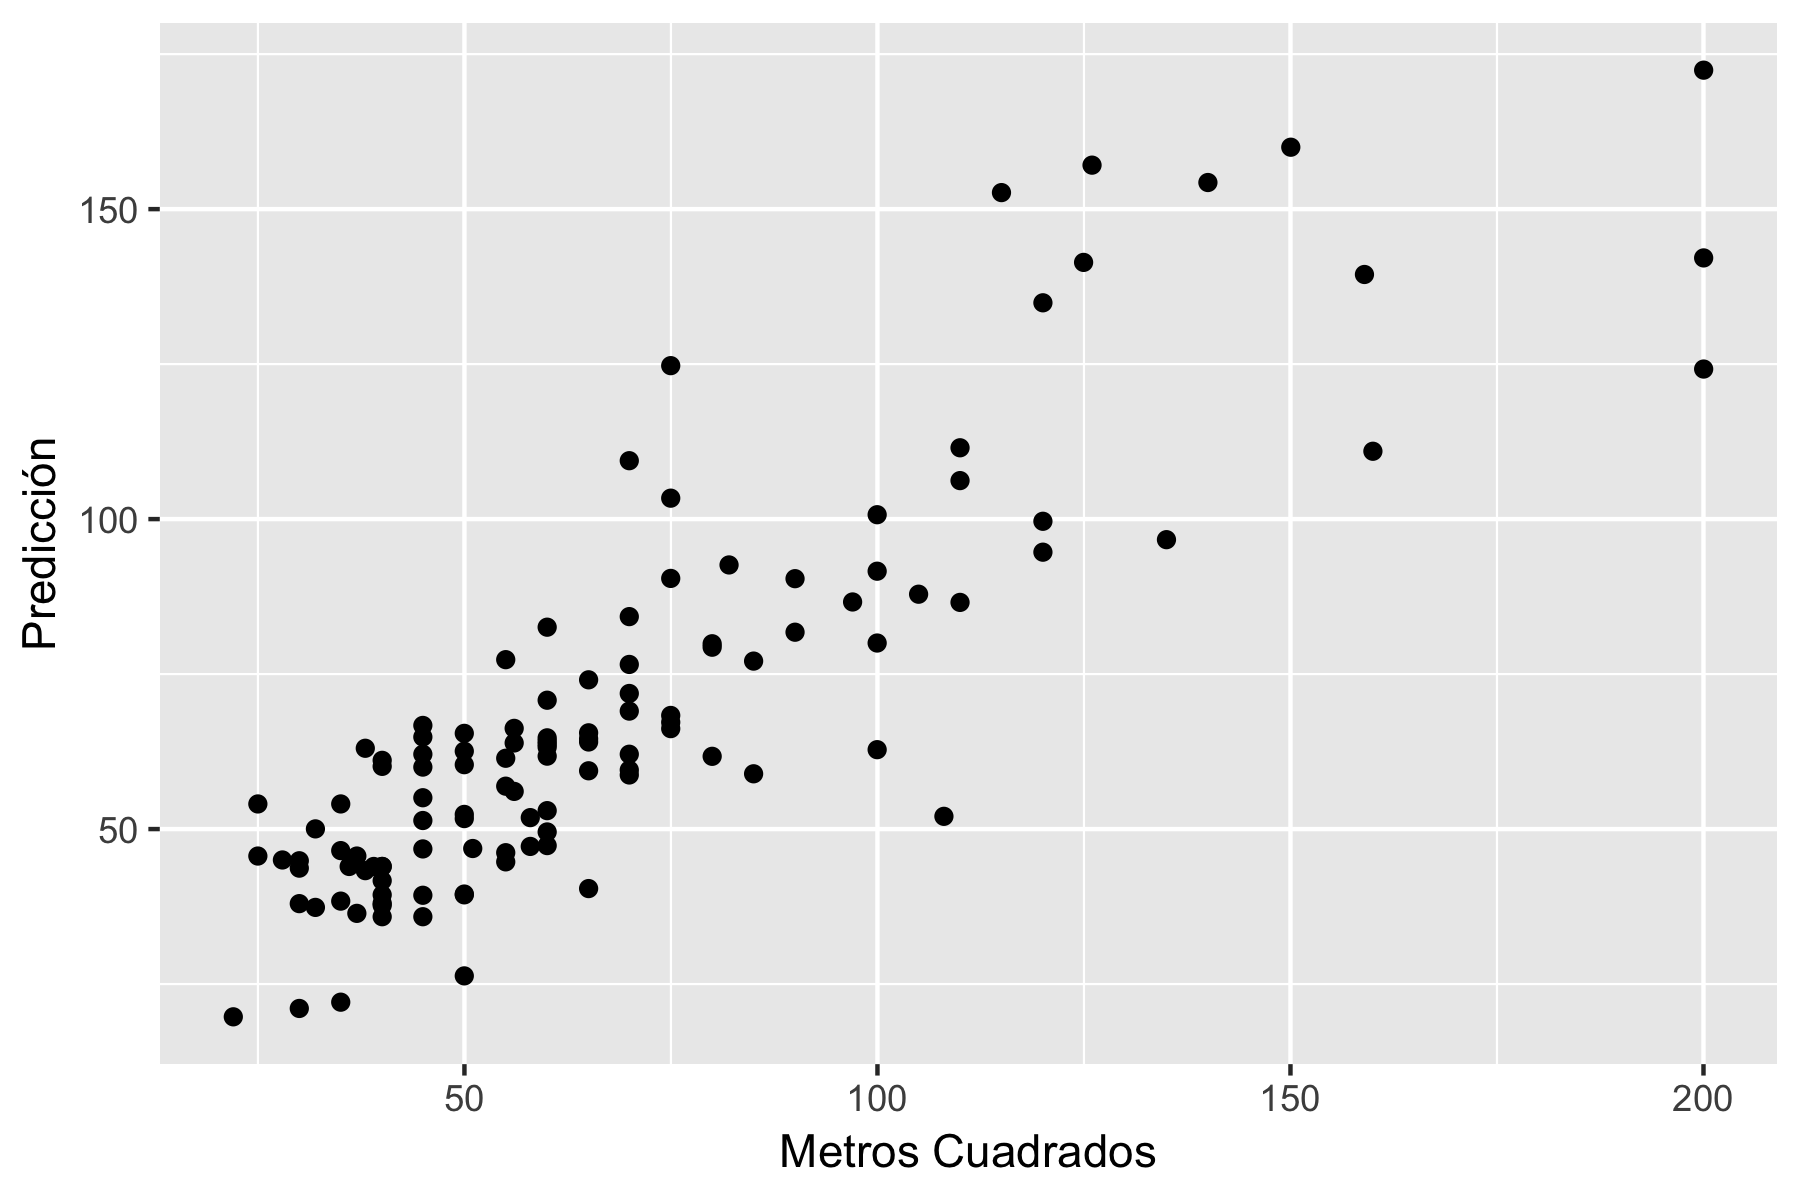

In [35]:
# Predecimos sobre train y calculamos los residuos:
train$predict <- predict(modelo2, train)
ggplot(train, aes(x = Square.Meters, y = Square.Meters - predict))+ geom_point() +ylab("Residuos")+xlab("Metros Cuadrados")
ggplot(train, aes(x = Square.Meters, y = predict))+ geom_point() +ylab("Predicción")+xlab("Metros Cuadrados")

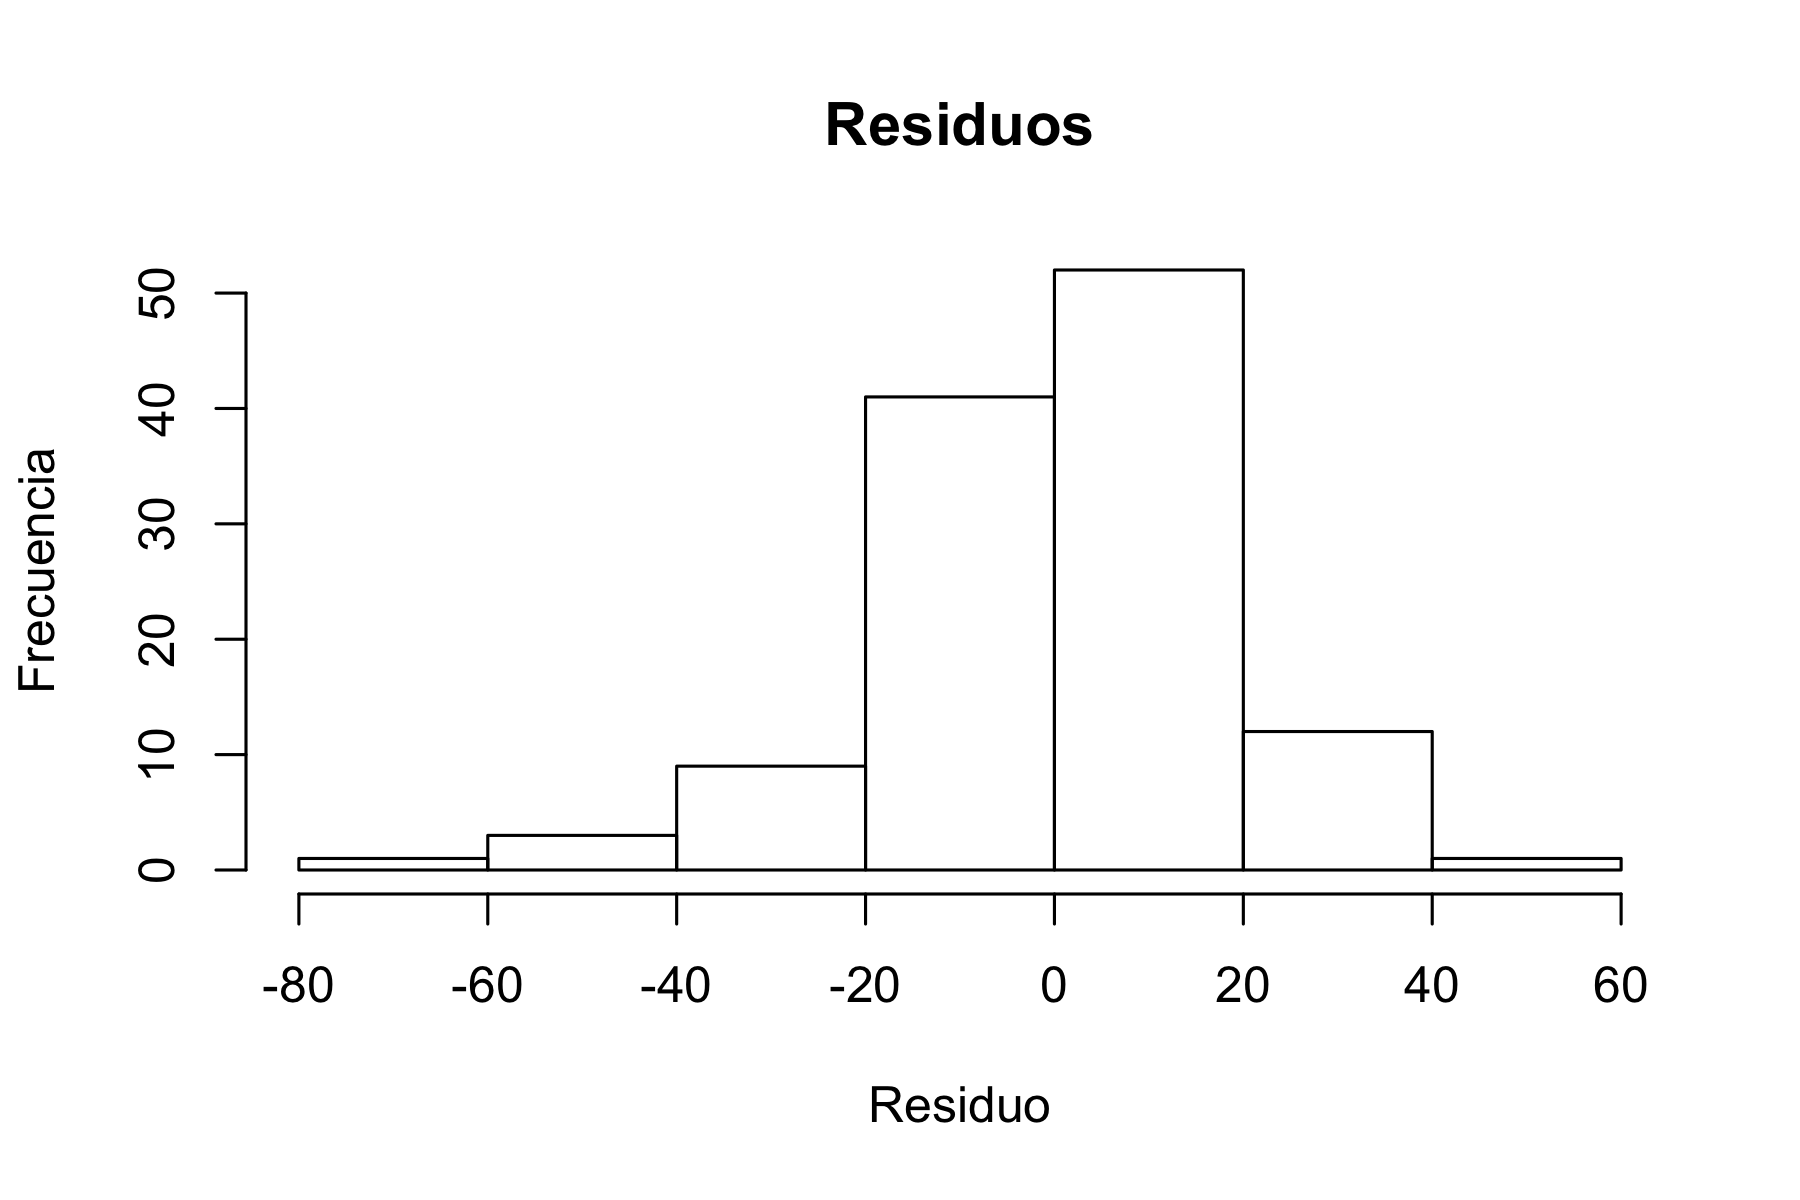

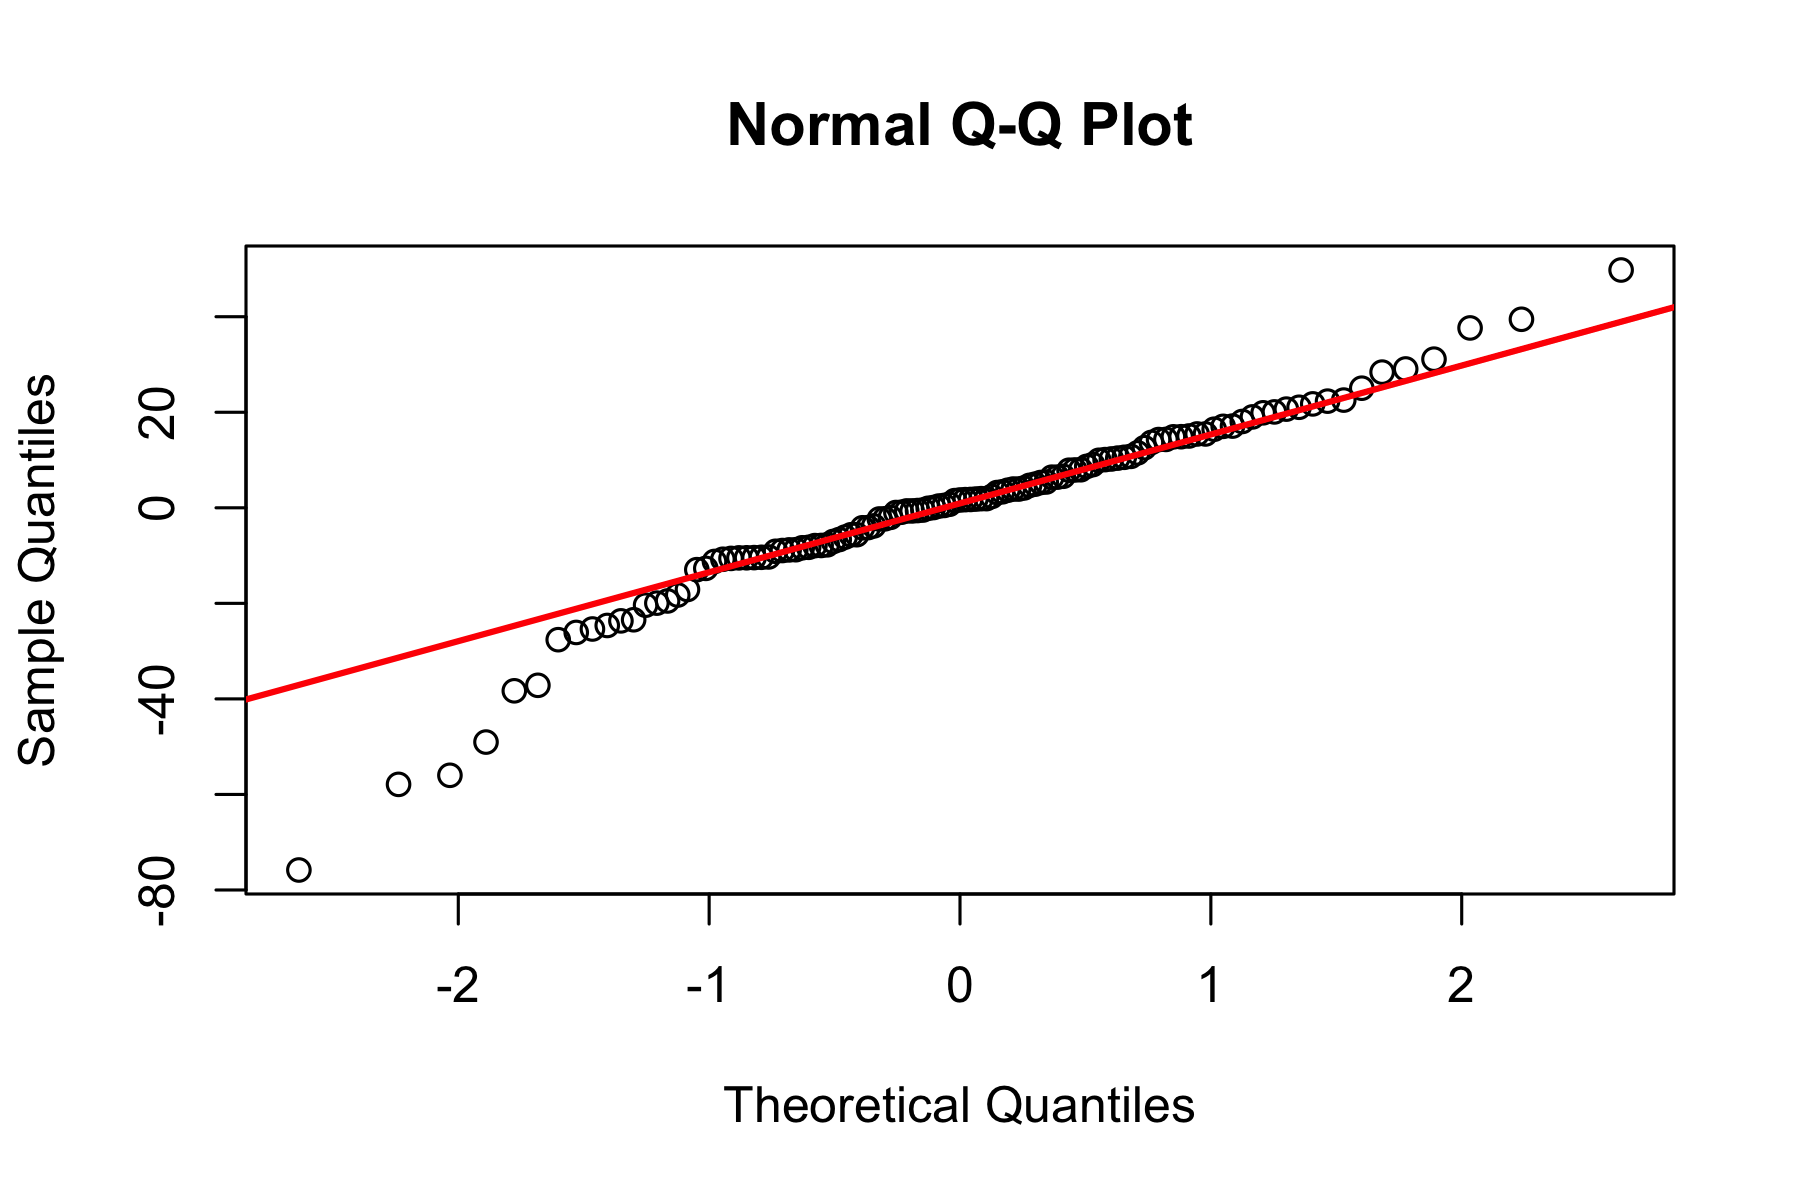

In [22]:
hist(train$predict-train$Square.Meters, main = "Residuos", xlab = "Residuo", ylab = "Frecuencia")
qqnorm(train$predict-train$Square.Meters)
qqline(train$predict-train$Square.Meters, col = "red", lwd = 2)

In [23]:
# Evaluamos nuestro modelo para después poder comparar con los resultados en test:
caret::postResample(pred = train$predict, obs = train$Square.Meters)

RMSE   Rsquared        MAE 
18.7836060  0.7384519 13.4522494

Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_point).”

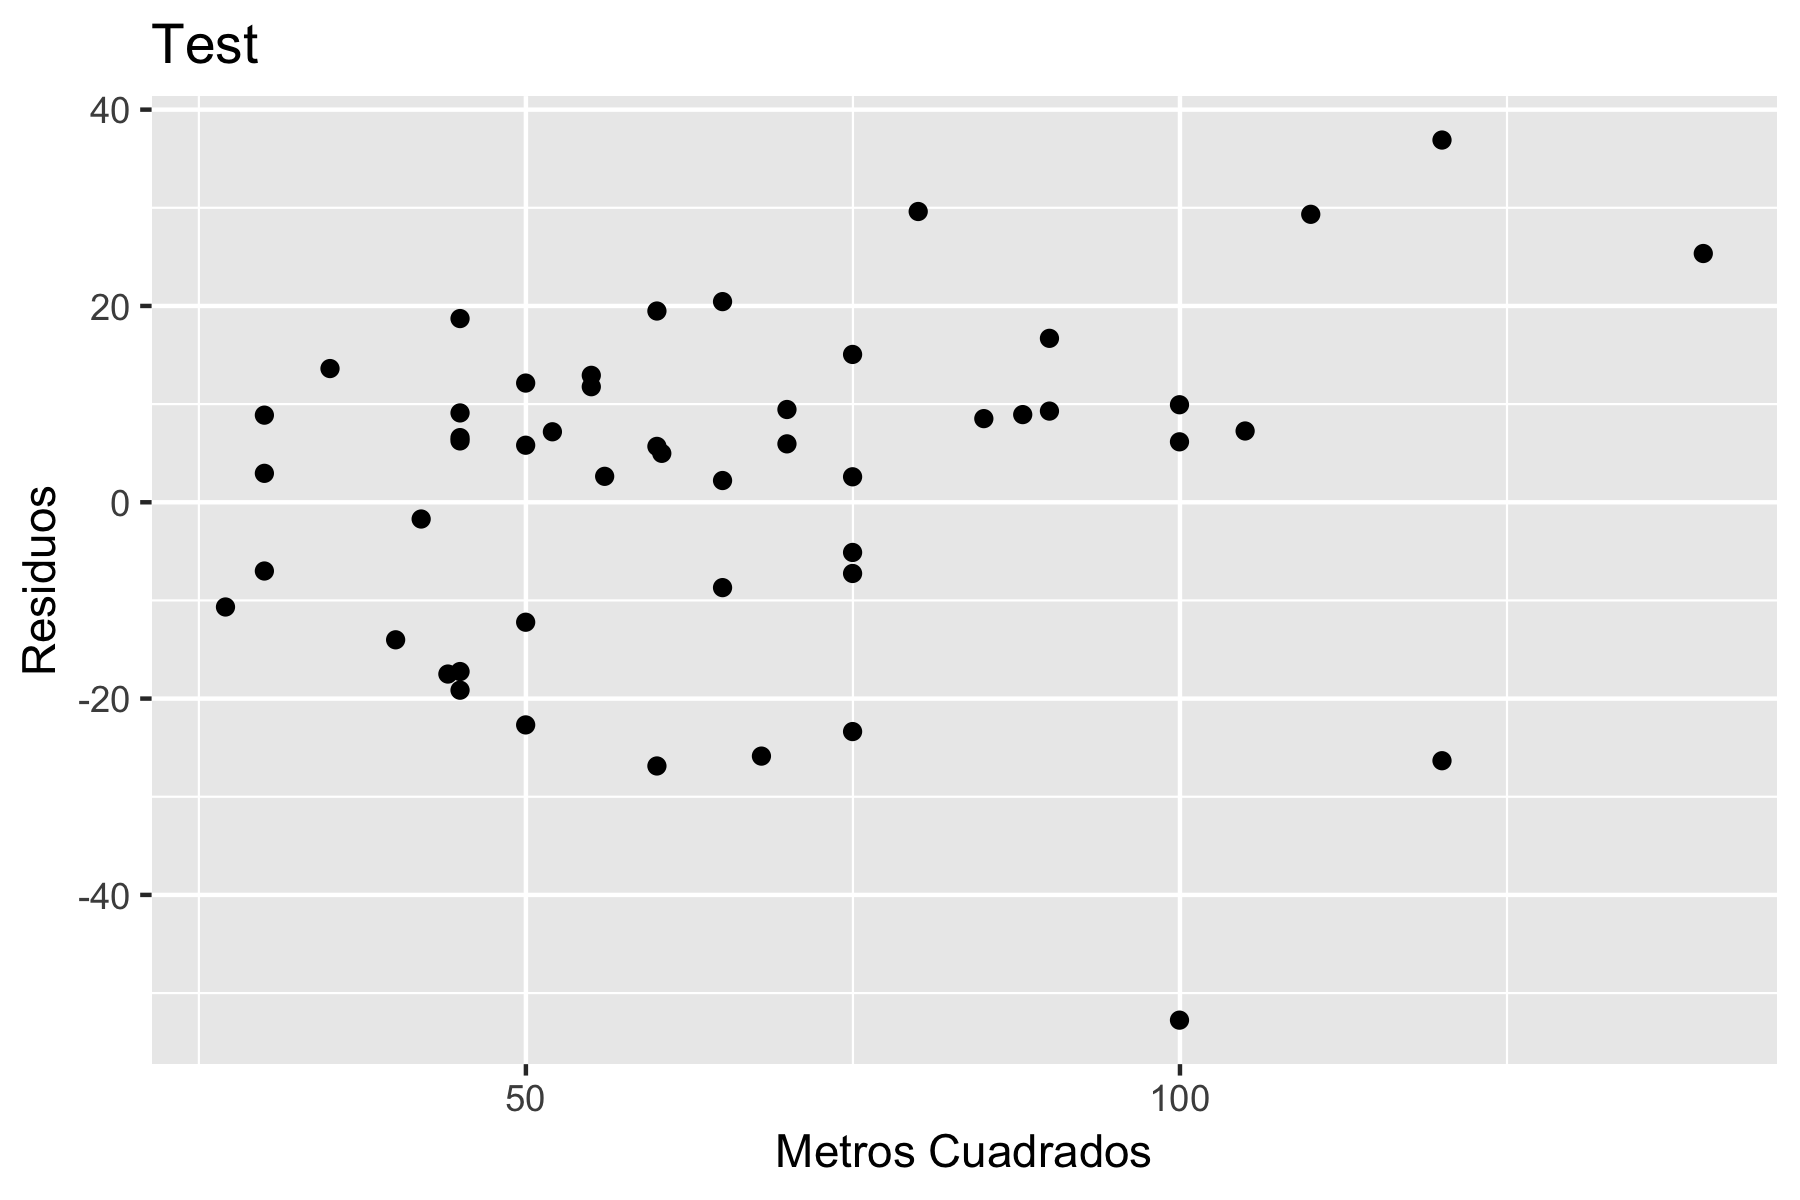

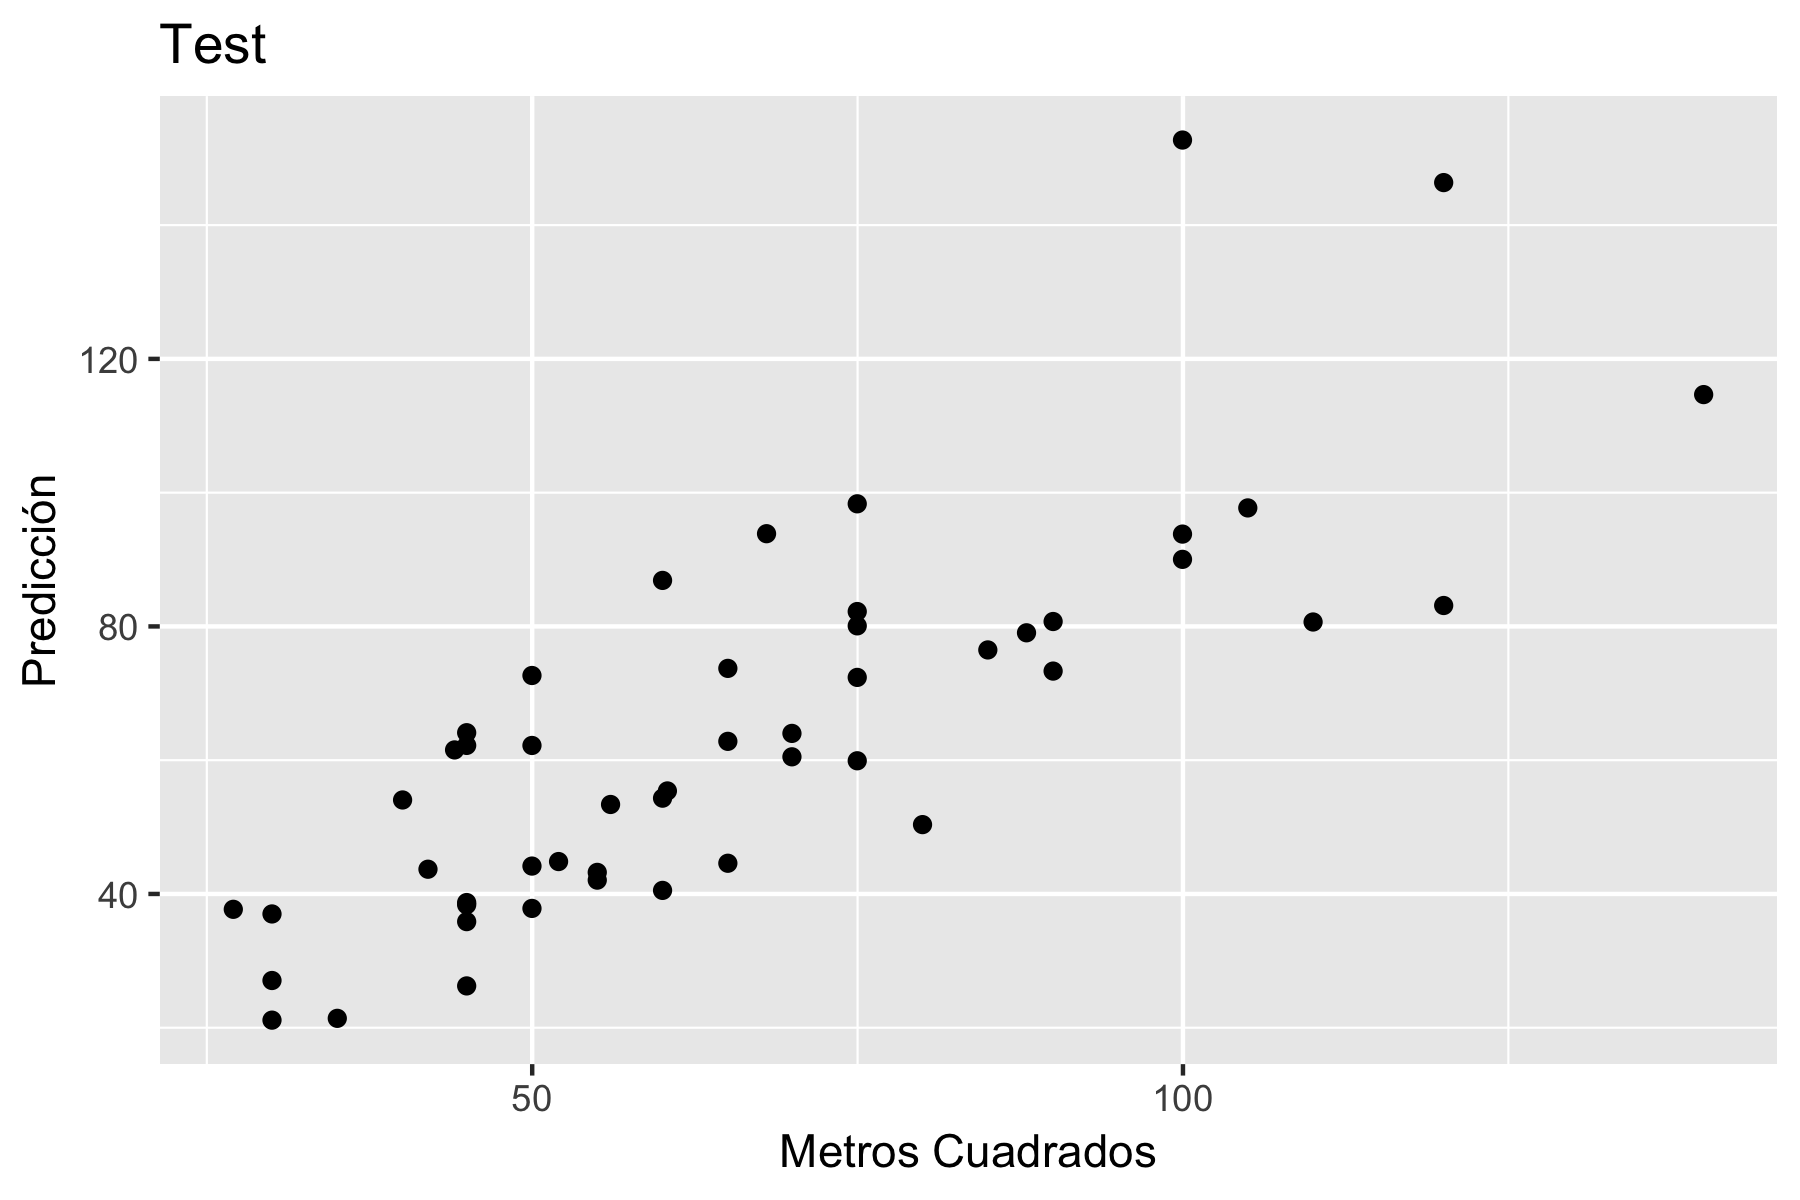

In [24]:
# Predecimos en test:
test$predict <- predict(modelo2, test)
ggplot(test, aes(x = Square.Meters, y = Square.Meters - predict))+ geom_point() +ylab("Residuos")+xlab("Metros Cuadrados") + ggtitle("Test")
ggplot(test, aes(x = Square.Meters, y = predict))+ geom_point() +ylab("Predicción")+xlab("Metros Cuadrados")+ ggtitle("Test")

In [25]:
# Evaluamos el modelo:
caret::postResample(pred = test$predict, obs = test$Square.Meters)

RMSE   Rsquared        MAE 
17.0670285  0.6456128 13.8174007

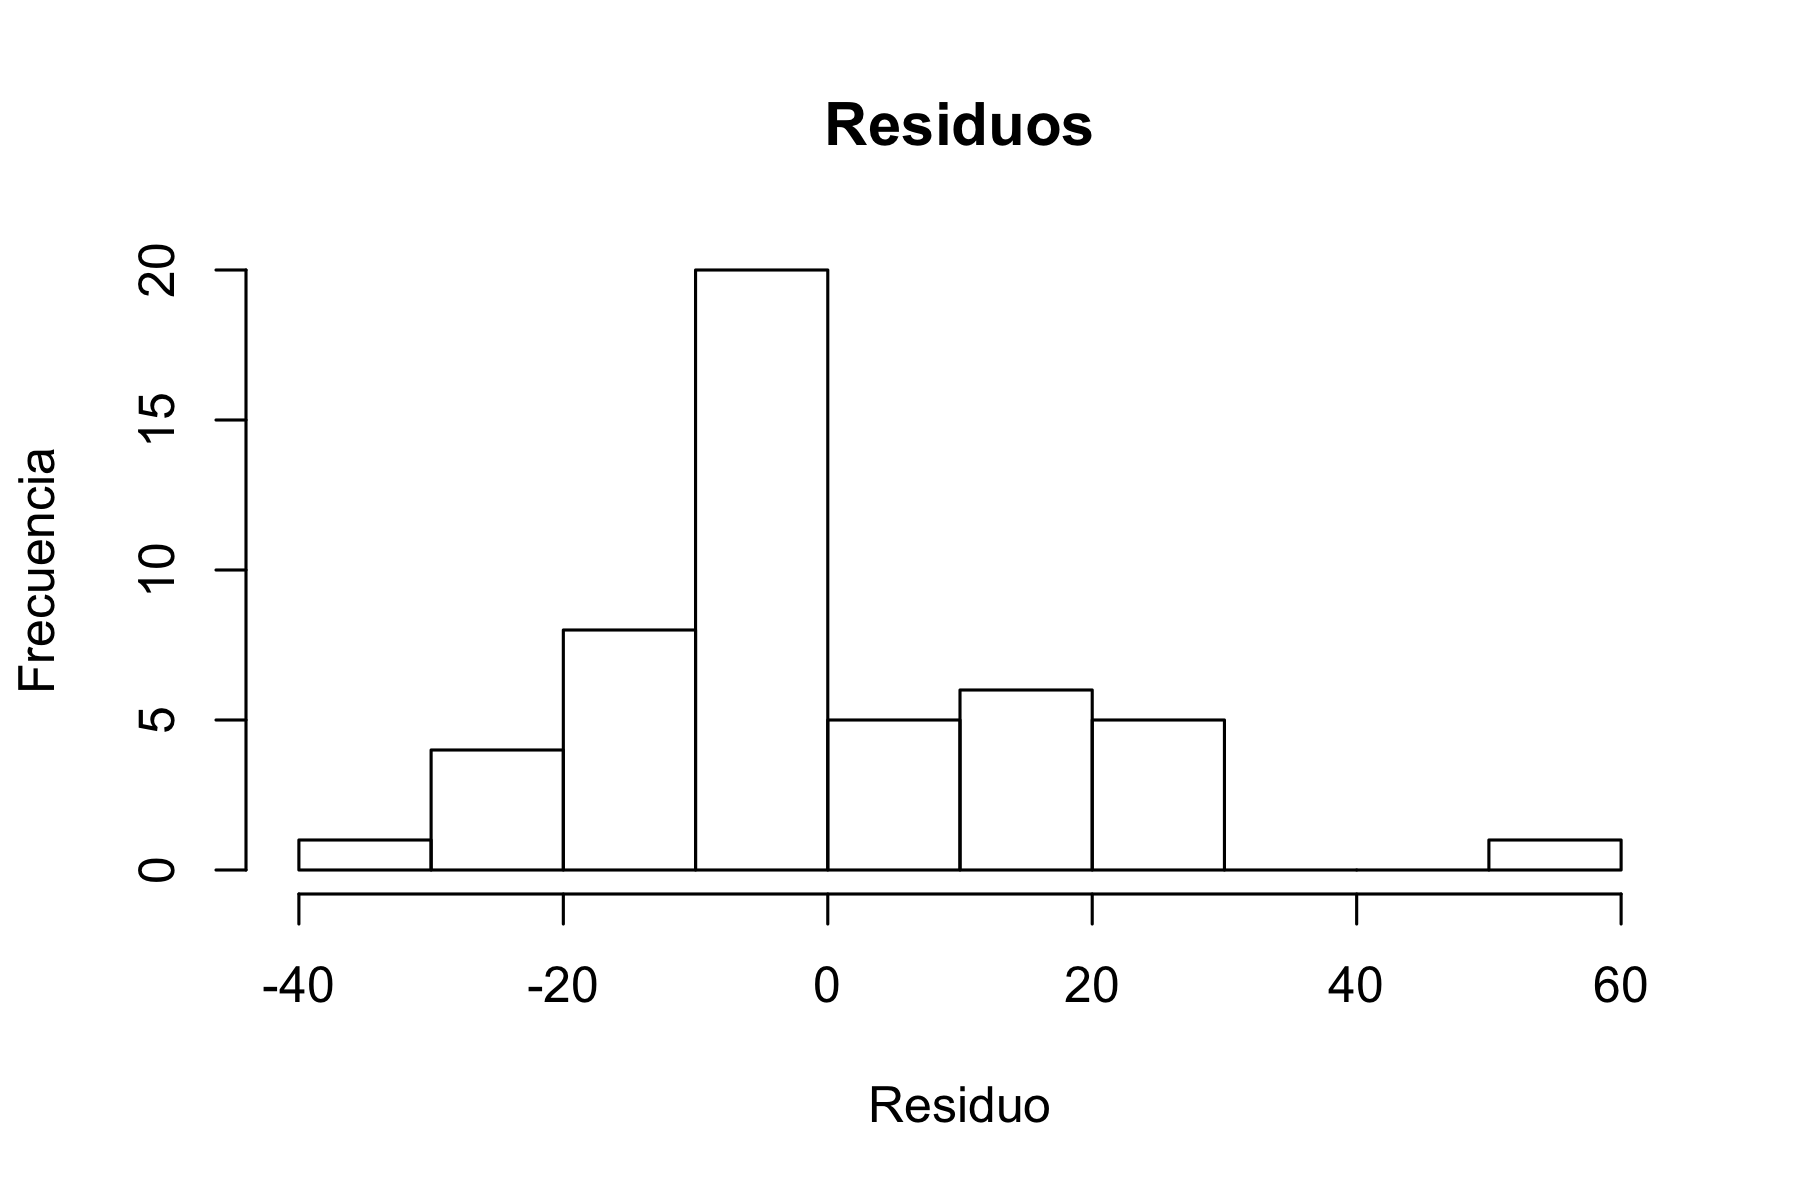

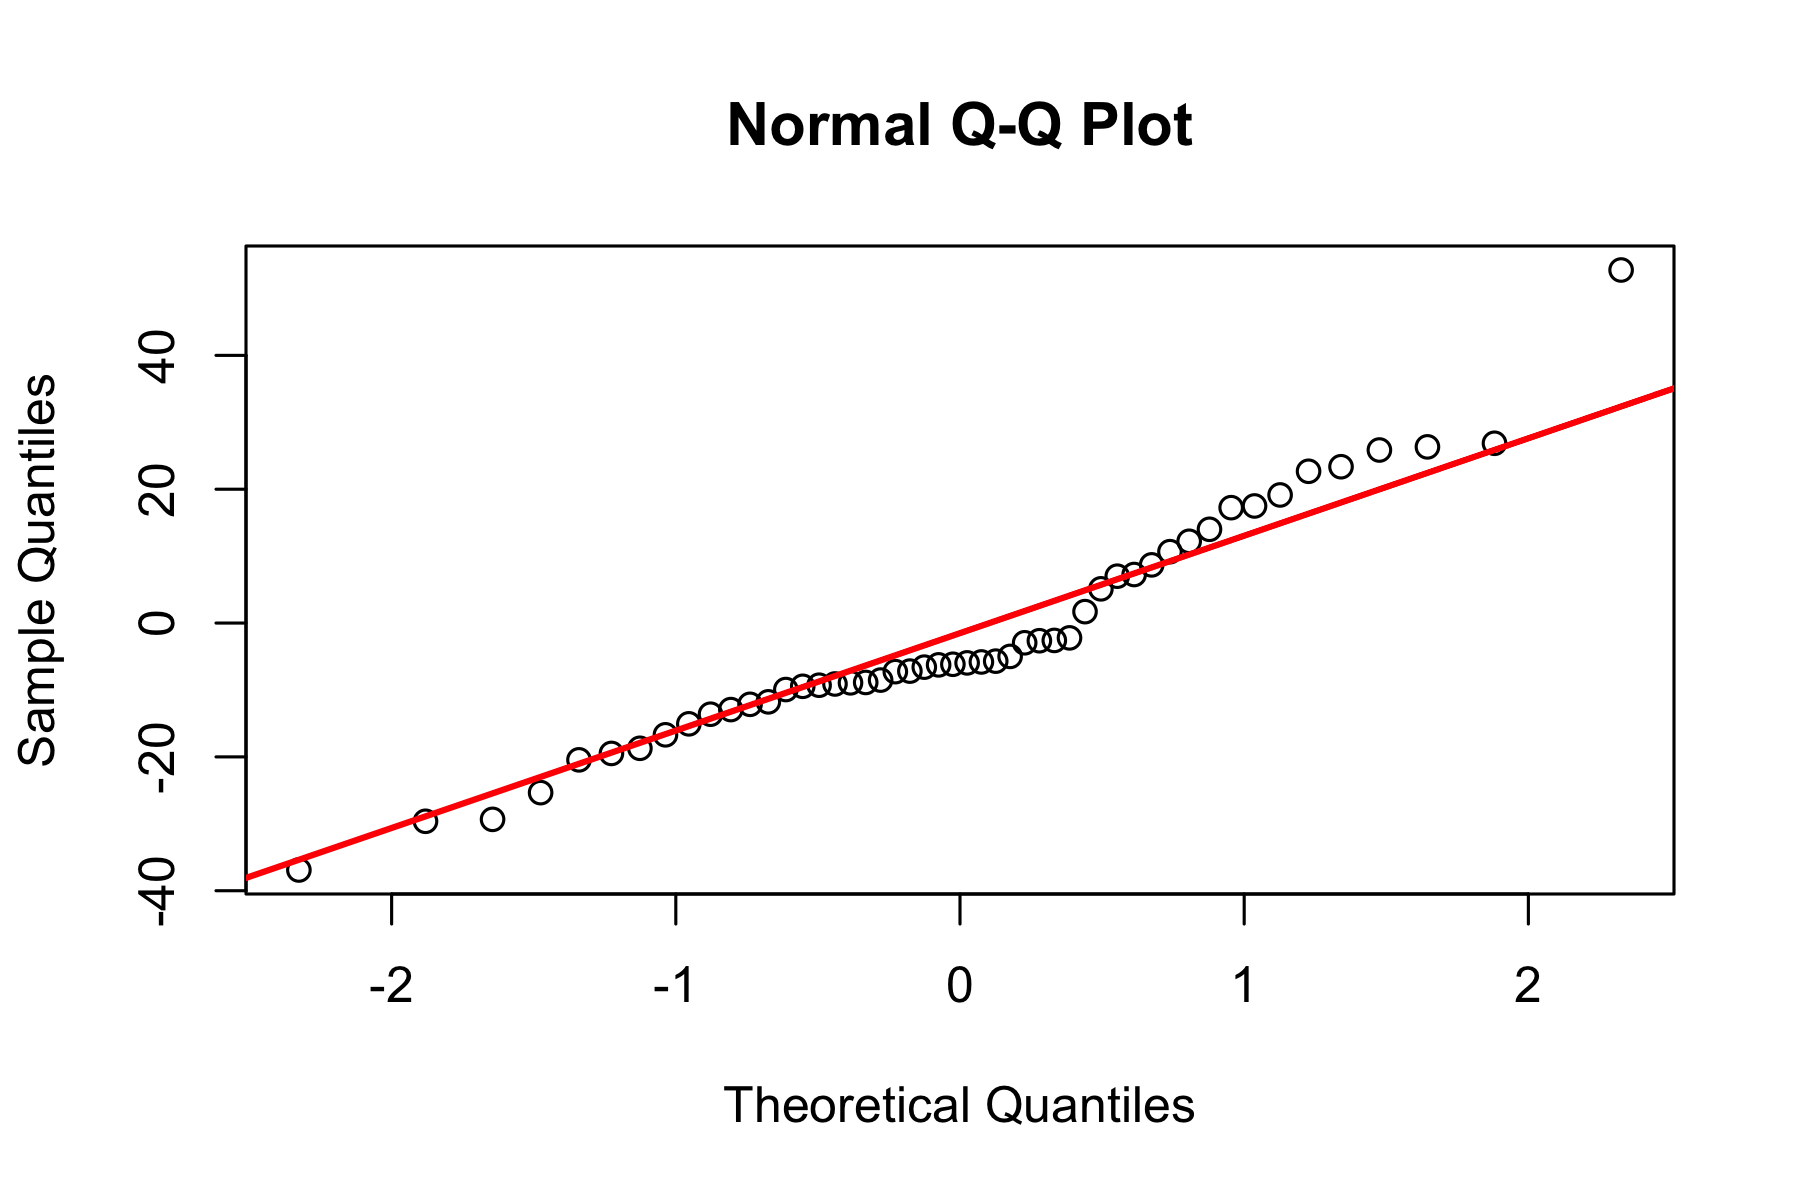

In [26]:
hist(test$predict-test$Square.Meters, main = "Residuos", xlab = "Residuo", ylab = "Frecuencia")
qqnorm(test$predict-test$Square.Meters)
qqline(test$predict-test$Square.Meters, col = "red", lwd = 2)

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates), con 1 baño, con un precio de 80€/noche y 3 habitaciones en el barrio de Sol, con 3 camas y un review de 80.
¿Cuantos metros cuadrados tendría? Si tu modelo necesita algúna variable adicional puedes inventartela dentro del rango de valores del dataset.
¿Como varía sus metros cuadrados con cada habitación adicional?

In [27]:
anuncio <- data.frame(Bathrooms=1, Bedrooms=3, Guests.Included=2, Price= 80, Extra.People=4, neighb_id=as.factor(1))
paste("Tendría según nuestro modelo: ", predict(modelo2, anuncio), "metros cuadrados.")

[1] "Tendría según nuestro modelo:  91.9533009421579 metros cuadrados."

In [28]:
paste("Con cada habitación adicional sus metros cuadrados aumentarían en: ", modelo2$coefficients[3])

[1] "Con cada habitación adicional sus metros cuadrados aumentarían en:  17.312752558096"

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [29]:
for (i in 1:nrow(df_madrid_cluster)) {
  if(is.na(df_madrid_cluster[i,"Square.Meters"])) {
      df_madrid_cluster[i,"Square.Meters"]<-predict(modelo2,df_madrid_cluster[i,])
  }
}

Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [30]:
df_pca <- na.omit(df_madrid_cluster[,c("Accommodates", "Bathrooms", "Bedrooms", "Beds", "Price", "Guests.Included", "Extra.People", "Review.Scores.Rating", "Latitude", "Longitude", "Square.Meters")])
pr_madrid <- prcomp(df_pca, center = TRUE, scale. = TRUE)

In [31]:
id_test_apart <- 150
apart_test <- matrix(pr_madrid$x[id_test_apart,1:11],nrow=1)

In [32]:
dist <- rowSums((pr_madrid$x[,1:11]-apart_test[rep(1, times = nrow(pr_madrid$x[,1:11])), ])^2)

In [33]:
piso <- which.min(dist)
if (piso == id_test_apart) {
    paste("Se ha realizado correctamente el calculo de distancias para el piso de características:")
    df_pca[piso,]
}

piso1 <- which.min(dist[-piso])
piso2 <- which.min(dist[-c(piso,piso1)])
piso3 <- which.min(dist[-c(piso,piso1,piso2)])
piso4 <- which.min(dist[-c(piso,piso1,piso2,piso3)])
piso5 <- which.min(dist[-c(piso,piso1,piso2,piso3,piso4)])

paste("Los pisos más similares son los que tienen las siguientes características")
df_pca[c(piso1, piso2, piso3, piso4, piso5), ]

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
210,2,1,1,1,95,2,10,82,40.43703,-3.709258,61.73444


[1] "Los pisos más similares son los que tienen las siguientes características"

,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
120,3,1,1,1,50,2,10,80,40.43735,-3.699373,58.69823
4853,6,2,2,4,130,2,10,100,40.43609,-3.701655,90.92045
4851,6,1,2,4,125,2,5,95,40.42958,-3.699976,78.24253
4850,6,1,1,4,45,2,25,100,40.43819,-3.701895,66.84730
4849,5,2,2,4,130,1,0,100,40.42957,-3.697999,85.26283


Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?